# Data Cleaning + EDA (Replacement Notebook) — Life Expectancy Modeling Dataset

This notebook is a **drop-in replacement** for `data_cleaning.ipynb`, but it uses your richer dataset `../Assets/2000_clean.csv` (WHO/World Bank merged).

It covers the same core tasks as the original notebook:

- **Initial exploratory analysis**
- **Missingness summary + plot**
- **Target outliers** (conservative 3×IQR)
- **Distributions & scatter plots**
- **Correlation analysis + heatmap**
- **Train/test split** (time-based, to avoid temporal leakage)

It also makes a **deliberate, justified feature-reduction pass** to remove or combine variables that carry essentially the same signal (to reduce multicollinearity and make the model more stable).

**Outputs:**
- `outputs/final_raw.csv` — cleaned + simplified features (can contain missing values)
- `outputs/final.csv` — model-ready version (missing flags + imputed using **train-only statistics**)
- `outputs/splits/train.csv`, `outputs/splits/test.csv` — splits for modeling
- Figures saved into `../Images/`

## Import & Load

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)

# Optional seaborn (used for nicer heatmaps)
try:
    import seaborn as sns
    sns.set_style("whitegrid")
    HAS_SEABORN = True
except Exception:
    HAS_SEABORN = False

# Paths
INPUT_PATH = Path("../Assets/2000_clean.csv")
OUT_DIR = Path("outputs")
IMG_DIR = Path("../Images")
SPLIT_DIR = OUT_DIR / "splits"

OUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

if not INPUT_PATH.exists():
    raise FileNotFoundError(
        f"Could not find {INPUT_PATH.resolve()}. "
        "Place 2000_clean.csv in ../Assets OR set INPUT_PATH to the full path."
    )

df = pd.read_csv(INPUT_PATH)

print("Loaded:", INPUT_PATH.resolve())
print("Dataset shape:", df.shape)
df.head(10)

Loaded: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/2000_clean.csv
Dataset shape: (6218, 40)


,Country,Year,adult_mortality_rate_15_60_per_1000__both_sexes,adult_mortality_rate_15_60_per_1000__female,adult_mortality_rate_15_60_per_1000__male,alcohol_consumption_litres_15plus__both_sexes,dtp3_immunization_pct_1yo,gdp_per_capita_const2015_usd,health_expenditure_pct_gdp,hepb3_immunization_pct_1yo,...,thinness_bmi_lt_minus2_pct__female__5_9_years,thinness_bmi_lt_minus2_pct__male__10_19_years,thinness_bmi_lt_minus2_pct__male__5_19_years,thinness_bmi_lt_minus2_pct__male__5_9_years,under5_mortality_rate_per_1000__both_sexes,under5_mortality_rate_per_1000__female,under5_mortality_rate_per_1000__male,underweight_adults_bmi_lt18_pct__both_sexes__18_years,underweight_adults_bmi_lt18_pct__female__18_years,underweight_adults_bmi_lt18_pct__male__18_years
0,Afghanistan,2000,378.0,373.0,383.0,0.0,24.0,308.318270,NaN,0.0,...,8.2,23.4,22.2,20.6,131.7,126.9,136.2,20.4,22.0,18.5
1,Afghanistan,2001,380.0,374.0,387.0,0.0,33.0,277.118051,NaN,0.0,...,8.0,22.8,21.6,20.0,127.4,122.9,131.8,19.6,21.2,17.8
2,Afghanistan,2002,367.0,368.0,367.0,0.0,36.0,338.139974,9.44,0.0,...,7.9,22.2,21.1,19.5,123.1,118.9,127.2,18.9,20.3,17.1
3,Afghanistan,2003,353.0,357.0,350.0,0.0,41.0,346.071627,8.94,0.0,...,7.7,21.6,20.5,18.9,118.7,114.4,122.9,18.1,19.5,16.3
4,Afghanistan,2004,346.0,349.0,343.0,0.0,50.0,338.637274,9.81,0.0,...,7.6,21.0,19.9,18.3,114.2,109.8,118.4,17.3,18.7,15.6
5,Afghanistan,2005,343.0,345.0,341.0,0.0,58.0,363.640141,9.95,0.0,...,7.4,20.3,19.3,17.8,109.7,105.3,113.8,16.5,17.9,14.9
6,Afghanistan,2006,342.0,340.0,344.0,0.0,58.0,367.758312,10.62,0.0,...,7.3,19.7,18.7,17.2,105.1,100.7,109.3,15.7,17.1,14.2
7,Afghanistan,2007,339.0,334.0,343.0,0.0,63.0,410.757729,9.90,63.0,...,7.1,19.1,18.1,16.7,100.7,96.3,104.8,15.0,16.3,13.5
8,Afghanistan,2008,329.0,327.0,330.0,0.0,64.0,417.647283,10.26,64.0,...,7.0,18.5,17.6,16.1,96.3,92.0,100.4,14.3,15.5,12.8
9,Afghanistan,2009,320.0,317.0,322.0,0.0,63.0,488.830652,9.82,63.0,...,6.8,17.9,17.0,15.6,92.2,88.0,96.2,13.5,14.7,12.1


## Initial Exploration

Column Information:


,dtype
Country,str
Year,int64
adult_mortality_rate_15_60_per_1000__both_sexes,float64
adult_mortality_rate_15_60_per_1000__female,float64
adult_mortality_rate_15_60_per_1000__male,float64
alcohol_consumption_litres_15plus__both_sexes,float64
dtp3_immunization_pct_1yo,float64
gdp_per_capita_const2015_usd,float64
health_expenditure_pct_gdp,float64
hepb3_immunization_pct_1yo,float64



Preview:


,Country,Year,adult_mortality_rate_15_60_per_1000__both_sexes,adult_mortality_rate_15_60_per_1000__female,adult_mortality_rate_15_60_per_1000__male,alcohol_consumption_litres_15plus__both_sexes,dtp3_immunization_pct_1yo,gdp_per_capita_const2015_usd,health_expenditure_pct_gdp,hepb3_immunization_pct_1yo,...,thinness_bmi_lt_minus2_pct__female__5_9_years,thinness_bmi_lt_minus2_pct__male__10_19_years,thinness_bmi_lt_minus2_pct__male__5_19_years,thinness_bmi_lt_minus2_pct__male__5_9_years,under5_mortality_rate_per_1000__both_sexes,under5_mortality_rate_per_1000__female,under5_mortality_rate_per_1000__male,underweight_adults_bmi_lt18_pct__both_sexes__18_years,underweight_adults_bmi_lt18_pct__female__18_years,underweight_adults_bmi_lt18_pct__male__18_years
0,Afghanistan,2000,378.0,373.0,383.0,0.0,24.0,308.318270,NaN,0.0,...,8.2,23.4,22.2,20.6,131.7,126.9,136.2,20.4,22.0,18.5
1,Afghanistan,2001,380.0,374.0,387.0,0.0,33.0,277.118051,NaN,0.0,...,8.0,22.8,21.6,20.0,127.4,122.9,131.8,19.6,21.2,17.8
2,Afghanistan,2002,367.0,368.0,367.0,0.0,36.0,338.139974,9.44,0.0,...,7.9,22.2,21.1,19.5,123.1,118.9,127.2,18.9,20.3,17.1
3,Afghanistan,2003,353.0,357.0,350.0,0.0,41.0,346.071627,8.94,0.0,...,7.7,21.6,20.5,18.9,118.7,114.4,122.9,18.1,19.5,16.3
4,Afghanistan,2004,346.0,349.0,343.0,0.0,50.0,338.637274,9.81,0.0,...,7.6,21.0,19.9,18.3,114.2,109.8,118.4,17.3,18.7,15.6
5,Afghanistan,2005,343.0,345.0,341.0,0.0,58.0,363.640141,9.95,0.0,...,7.4,20.3,19.3,17.8,109.7,105.3,113.8,16.5,17.9,14.9
6,Afghanistan,2006,342.0,340.0,344.0,0.0,58.0,367.758312,10.62,0.0,...,7.3,19.7,18.7,17.2,105.1,100.7,109.3,15.7,17.1,14.2
7,Afghanistan,2007,339.0,334.0,343.0,0.0,63.0,410.757729,9.90,63.0,...,7.1,19.1,18.1,16.7,100.7,96.3,104.8,15.0,16.3,13.5
8,Afghanistan,2008,329.0,327.0,330.0,0.0,64.0,417.647283,10.26,64.0,...,7.0,18.5,17.6,16.1,96.3,92.0,100.4,14.3,15.5,12.8
9,Afghanistan,2009,320.0,317.0,322.0,0.0,63.0,488.830652,9.82,63.0,...,6.8,17.9,17.0,15.6,92.2,88.0,96.2,13.5,14.7,12.1



Basic stats (numeric):


,count,mean,std,min,25%,50%,75%,max
Year,6218.0,2.011987e+03,7.204998e+00,2000.000000,2006.000000,2.012000e+03,2.018000e+03,2.024000e+03
adult_mortality_rate_15_60_per_1000__both_sexes,4070.0,1.858646e+02,1.144243e+02,43.000000,102.000000,1.590000e+02,2.440000e+02,7.510000e+02
adult_mortality_rate_15_60_per_1000__female,4070.0,1.495511e+02,1.111871e+02,25.000000,71.000000,1.115000e+02,2.020000e+02,7.300000e+02
adult_mortality_rate_15_60_per_1000__male,4070.0,2.216867e+02,1.228239e+02,52.000000,130.000000,2.010000e+02,2.860000e+02,7.930000e+02
alcohol_consumption_litres_15plus__both_sexes,4324.0,5.535453e+00,4.199443e+00,0.000000,1.800000,4.900000e+00,8.700000e+00,1.950000e+01
dtp3_immunization_pct_1yo,4831.0,8.685862e+01,1.450707e+01,19.000000,82.000000,9.300000e+01,9.700000e+01,9.900000e+01
gdp_per_capita_const2015_usd,5136.0,1.555255e+04,2.284526e+04,233.032393,1909.694404,5.704357e+03,2.031291e+04,2.471702e+05
health_expenditure_pct_gdp,4588.0,6.274821e+00,3.156830e+00,1.220000,4.120000,5.660000e+00,7.990000e+00,7.973000e+01
hepb3_immunization_pct_1yo,4831.0,7.533430e+01,3.190446e+01,0.000000,71.000000,9.000000e+01,9.600000e+01,9.900000e+01
hiv_prevalence_15_49_pct,1329.0,1.674718e+00,4.040204e+00,0.100000,0.100000,3.000000e-01,1.200000e+00,2.930000e+01



Categorical summary:
Countries: 249
Year range: 2000 to 2024

Top 10 countries by row count:


,rows
Country,
Afghanistan,25
Albania,25
Algeria,25
American Samoa,25
Andorra,25
Angola,25
Antigua and Barbuda,25
Argentina,25
Armenia,25


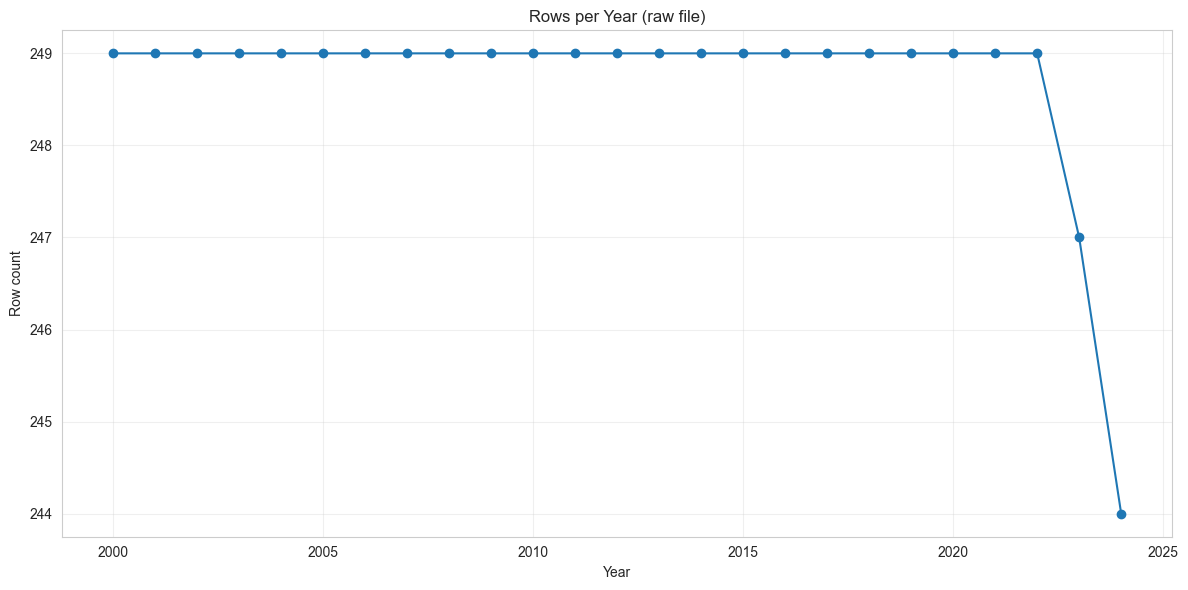

In [2]:
print("Column Information:")
display(df.dtypes.to_frame("dtype"))

print("\nPreview:")
display(df.head(10))

print("\nBasic stats (numeric):")
display(df.describe().T)

# Categorical summary (this dataset is mostly numeric; Country is key categorical)
print("\nCategorical summary:")
print("Countries:", df["Country"].nunique())
print("Year range:", int(pd.to_numeric(df["Year"], errors="coerce").min()), "to", int(pd.to_numeric(df["Year"], errors="coerce").max()))
print("\nTop 10 countries by row count:")
display(df["Country"].value_counts().head(10).to_frame("rows"))

# Rows per year
rows_per_year = df.groupby("Year").size().sort_index()
plt.figure()
plt.plot(rows_per_year.index, rows_per_year.values, marker="o")
plt.title("Rows per Year (raw file)")
plt.xlabel("Year")
plt.ylabel("Row count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(IMG_DIR / "rows_per_year_raw.png", dpi=200, bbox_inches="tight")
plt.show()

## Missing Values

Missing Value Summary (only columns with missing):


,Column,Missing_Count,Missing_Percentage
hiv_prevalence_15_49_pct,hiv_prevalence_15_49_pct,4889,78.63
life_expectancy_age60_years__both_sexes,life_expectancy_age60_years__both_sexes,2148,34.54
life_expectancy_birth_years__female,life_expectancy_birth_years__female,2148,34.54
life_expectancy_birth_years__both_sexes,life_expectancy_birth_years__both_sexes,2148,34.54
life_expectancy_age60_years__male,life_expectancy_age60_years__male,2148,34.54
life_expectancy_age60_years__female,life_expectancy_age60_years__female,2148,34.54
life_expectancy_birth_years__male,life_expectancy_birth_years__male,2148,34.54
adult_mortality_rate_15_60_per_1000__male,adult_mortality_rate_15_60_per_1000__male,2148,34.54
adult_mortality_rate_15_60_per_1000__female,adult_mortality_rate_15_60_per_1000__female,2148,34.54
adult_mortality_rate_15_60_per_1000__both_sexes,adult_mortality_rate_15_60_per_1000__both_sexes,2148,34.54


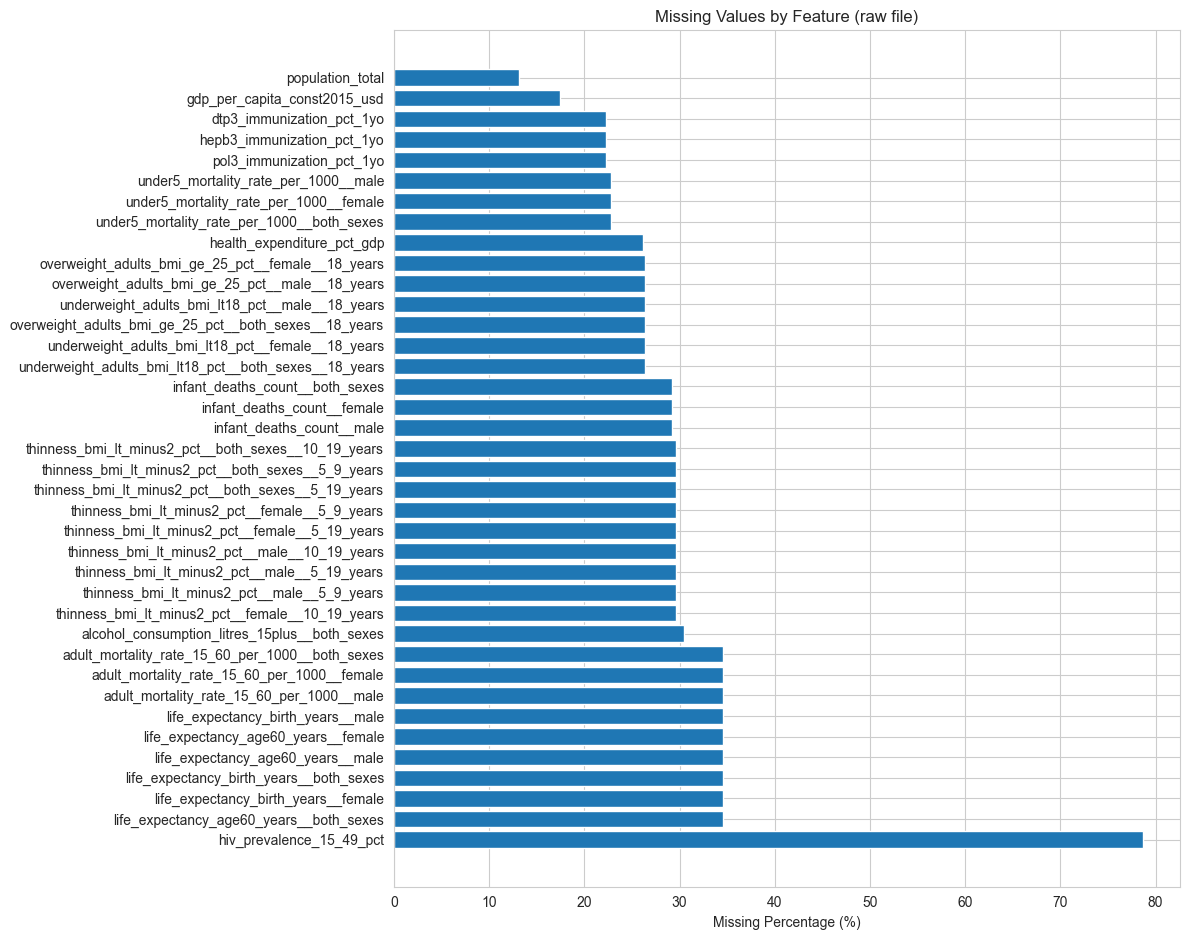

In [3]:
missing_data = pd.DataFrame({
    "Column": df.columns,
    "Missing_Count": df.isnull().sum(),
    "Missing_Percentage": (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values("Missing_Count", ascending=False)

missing_data = missing_data[missing_data["Missing_Count"] > 0]

print("Missing Value Summary (only columns with missing):")
display(missing_data)

# Visualize missing values
if len(missing_data) > 0:
    plt.figure(figsize=(12, max(6, 0.25 * len(missing_data))))
    plt.barh(missing_data["Column"], missing_data["Missing_Percentage"])
    plt.xlabel("Missing Percentage (%)")
    plt.title("Missing Values by Feature (raw file)")
    plt.tight_layout()
    plt.savefig(IMG_DIR / "missing_values_raw.png", dpi=200, bbox_inches="tight")
    plt.show()
else:
    print("No missing values found.")

## Cleaning Steps

### Target Definition

In the original notebook, the target was a single column (`Life expectancy`).

Here, we have multiple life expectancy variants (by sex and age group).  
To avoid **label leakage** and avoid having multiple highly redundant targets/predictors, we will use:

- **Target:** `life_expectancy_birth_years__both_sexes`

and we will later remove other life expectancy columns from the feature set.

In [4]:
# Basic cleanup (types)
df_clean = df.copy()

df_clean["Country"] = df_clean["Country"].astype(str).str.strip()
df_clean["Year"] = pd.to_numeric(df_clean["Year"], errors="coerce").astype("Int64")

# Drop rows missing key identifiers
before = len(df_clean)
df_clean = df_clean.dropna(subset=["Country", "Year"]).copy()
print(f"Dropped {before - len(df_clean)} rows missing Country/Year")

TARGET = "life_expectancy_birth_years__both_sexes"
if TARGET not in df_clean.columns:
    raise ValueError(f"Target not found: {TARGET}")

# Drop years with 0 target coverage (these years cannot be used for training)
year_coverage = df_clean.groupby("Year")[TARGET].apply(lambda s: s.notna().mean()).sort_index()
zero_years = year_coverage[year_coverage == 0].index.tolist()

print("Target non-missing % by year (tail):")
display((year_coverage * 100).round(1).tail(10).to_frame("target_non_missing_%"))

if zero_years:
    print("Dropping years with 0 target coverage:", zero_years)
    df_clean = df_clean[~df_clean["Year"].isin(zero_years)].copy()

print("Shape after dropping zero-coverage years:", df_clean.shape)

Dropped 0 rows missing Country/Year
Target non-missing % by year (tail):


,target_non_missing_%
Year,
2015,74.3
2016,74.3
2017,74.3
2018,74.3
2019,74.3
2020,74.3
2021,74.3
2022,0.0
2023,0.0


Dropping years with 0 target coverage: [2022, 2023, 2024]
Shape after dropping zero-coverage years: (5478, 40)


### Remove Missing Target

In [5]:
rows_before = len(df_clean)
df_clean = df_clean.dropna(subset=[TARGET]).copy()
print(f"Removed {rows_before - len(df_clean)} rows with missing target ({TARGET})")
print("Remaining:", df_clean.shape)

Removed 1408 rows with missing target (life_expectancy_birth_years__both_sexes)
Remaining: (4070, 40)


### Duplicates (Country-Year)

In [6]:
duplicates = df_clean.duplicated(subset=["Country", "Year"], keep=False)
print(f"Duplicate Country-Year pairs: {duplicates.sum()}")

if duplicates.any():
    display(df_clean.loc[duplicates].sort_values(["Country","Year"]).head(30))
    df_clean = df_clean.drop_duplicates(subset=["Country","Year"], keep="first").copy()
    print("After dropping duplicates:", df_clean.shape)

Duplicate Country-Year pairs: 0


### Target Outliers (3×IQR, conservative)

life_expectancy_birth_years__both_sexes range: 40.00 - 84.70
Outlier bounds (3*IQR): 27.80 - 113.20
Number of outliers flagged: 0


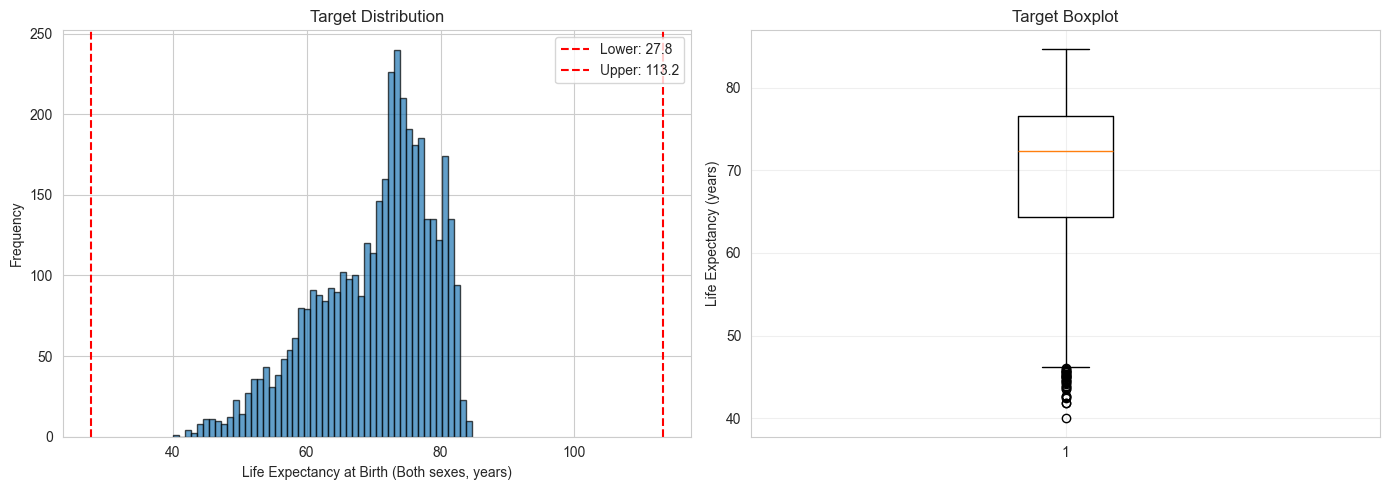

In [7]:
Q1 = df_clean[TARGET].quantile(0.25)
Q3 = df_clean[TARGET].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = df_clean[(df_clean[TARGET] < lower_bound) | (df_clean[TARGET] > upper_bound)]

print(f"{TARGET} range: {df_clean[TARGET].min():.2f} - {df_clean[TARGET].max():.2f}")
print(f"Outlier bounds (3*IQR): {lower_bound:.2f} - {upper_bound:.2f}")
print(f"Number of outliers flagged: {len(outliers)}")

if len(outliers) > 0:
    display(outliers[["Country","Year",TARGET]].head(10))

# Visualize target distribution (hist + box)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_clean[TARGET], bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(lower_bound, color="red", linestyle="--", label=f"Lower: {lower_bound:.1f}")
axes[0].axvline(upper_bound, color="red", linestyle="--", label=f"Upper: {upper_bound:.1f}")
axes[0].set_xlabel("Life Expectancy at Birth (Both sexes, years)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Target Distribution")
axes[0].legend()

axes[1].boxplot(df_clean[TARGET], vert=True)
axes[1].set_ylabel("Life Expectancy (years)")
axes[1].set_title("Target Boxplot")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(IMG_DIR / "target_distribution.png", dpi=200, bbox_inches="tight")
plt.show()

## Time Series Feature

In [8]:
print("Sorting by Country and Year...")
df_clean = df_clean.sort_values(["Country","Year"]).reset_index(drop=True)

# Simple temporal feature (safe)
df_clean["Years_Since_2000"] = df_clean["Year"].astype(int) - 2000

print("Dataset shape:", df_clean.shape)
df_clean[["Country","Year","Years_Since_2000",TARGET]].head(10)

Sorting by Country and Year...
Dataset shape: (4070, 41)


,Country,Year,Years_Since_2000,life_expectancy_birth_years__both_sexes
0,Afghanistan,2000,0,53.8
1,Afghanistan,2001,1,53.9
2,Afghanistan,2002,2,55.2
3,Afghanistan,2003,3,56.1
4,Afghanistan,2004,4,56.5
5,Afghanistan,2005,5,56.8
6,Afghanistan,2006,6,57.0
7,Afghanistan,2007,7,57.3
8,Afghanistan,2008,8,57.9
9,Afghanistan,2009,9,58.5


## Feature Simplification (Remove/Combine Redundant Variables)

Many columns in `../Assets/2000_clean.csv` are **near-duplicates** (e.g., the same indicator repeated for *female* and *male*).
Keeping all of them often causes:

- **Multicollinearity** (unstable coefficients and noisy feature importance)
- **Overfitting** (model learns small, meaningless differences between redundant measures)
- **Harder interpretation**

### Choices we will make

1) **Life expectancy columns**
- We are predicting **life expectancy at birth (both sexes)**, so we will:
  - keep `life_expectancy_birth_years__both_sexes` as the **target**
  - drop other life expectancy columns (age 60, and male/female variants) from predictors

2) **Sex-specific predictor variants**
- For indicators that exist as `{both_sexes, female, male}`, we will keep the **both_sexes** version to match the target definition and drop `female`/`male` duplicates.

3) **Immunization indicators**
- `dtp3`, `hepb3`, and `pol3` are all coverage rates that typically move together.
- We will combine them into **one composite**: `immunization_mean_pct`, and drop the individual ones.

4) **Thinness indicators**
- Thinness appears for multiple overlapping age groups (5–9, 10–19, 5–19).
- We will combine available thinness columns into a **single composite** `thinness_mean_pct` to reduce redundancy.

5) **Infant deaths**
- Counts are heavily tied to population size. We will convert to a comparable rate:
  - `infant_deaths_per_1000_population`
  and drop the raw count to reduce redundancy with `population_total`.

In [10]:
# ----------------------------
# Feature Simplification Cell (FIXED)
# ----------------------------

import re  # <-- Fix for NameError

# 1) Remove OTHER life expectancy columns (keep only the target)
lifeexp_cols = [c for c in df_clean.columns if str(c).startswith("life_expectancy_")]
leak_cols = [c for c in lifeexp_cols if c != TARGET]

print("Dropping life expectancy columns (non-target):")
print(leak_cols)

df_simplified = df_clean.drop(columns=leak_cols, errors="ignore").copy()

# 2) Drop sex-specific predictor duplicates (keep both_sexes)
drop_patterns = [
    r"__female$",
    r"__male$",
    r"__female__18_years$",
    r"__male__18_years$",
    r"__female__5_19_years$",
    r"__male__5_19_years$",
    r"__female__5_9_years$",
    r"__male__5_9_years$",
    r"__female__10_19_years$",
    r"__male__10_19_years$",
]

cols_to_drop = []
for c in df_simplified.columns:
    col_str = str(c)
    if any(re.search(pattern, col_str) for pattern in drop_patterns):
        cols_to_drop.append(c)

print(f"\nDropping {len(cols_to_drop)} sex-specific duplicate predictors:")
print(cols_to_drop)

df_simplified = df_simplified.drop(columns=cols_to_drop, errors="ignore")

# 3) Combine immunization metrics into one composite
immun_cols = [
    c for c in ["dtp3_immunization_pct_1yo",
                "hepb3_immunization_pct_1yo",
                "pol3_immunization_pct_1yo"]
    if c in df_simplified.columns
]

if len(immun_cols) >= 2:
    df_simplified["immunization_mean_pct"] = df_simplified[immun_cols].mean(axis=1, skipna=True)
    print("\nCreated immunization_mean_pct from:", immun_cols)
    df_simplified = df_simplified.drop(columns=immun_cols)
else:
    print("\nNot enough immunization columns found to combine:", immun_cols)

# 4) Combine thinness metrics (both sexes) into one composite
thin_cols = [
    c for c in df_simplified.columns
    if str(c).startswith("thinness_bmi_lt_minus2_pct__both_sexes")
]

if len(thin_cols) >= 2:
    df_simplified["thinness_mean_pct"] = df_simplified[thin_cols].mean(axis=1, skipna=True)
    print("\nCreated thinness_mean_pct from:", thin_cols)
    df_simplified = df_simplified.drop(columns=thin_cols)
else:
    print("\nNot enough thinness columns found to combine:", thin_cols)

# 5) Convert infant deaths count to rate and drop raw count
if "infant_deaths_count__both_sexes" in df_simplified.columns and "population_total" in df_simplified.columns:
    df_simplified["infant_deaths_per_1000_population"] = (
        df_simplified["infant_deaths_count__both_sexes"] /
        df_simplified["population_total"]
    ) * 1000

    df_simplified = df_simplified.drop(columns=["infant_deaths_count__both_sexes"])
    print("\nCreated infant_deaths_per_1000_population and dropped infant_deaths_count__both_sexes")

print("\nShape before simplification:", df_clean.shape)
print("Shape after simplification:", df_simplified.shape)

df_simplified.head()

Dropping life expectancy columns (non-target):
['life_expectancy_age60_years__both_sexes', 'life_expectancy_age60_years__female', 'life_expectancy_age60_years__male', 'life_expectancy_birth_years__female', 'life_expectancy_birth_years__male']

Dropping 16 sex-specific duplicate predictors:
['adult_mortality_rate_15_60_per_1000__female', 'adult_mortality_rate_15_60_per_1000__male', 'infant_deaths_count__female', 'infant_deaths_count__male', 'overweight_adults_bmi_ge_25_pct__female__18_years', 'overweight_adults_bmi_ge_25_pct__male__18_years', 'thinness_bmi_lt_minus2_pct__female__10_19_years', 'thinness_bmi_lt_minus2_pct__female__5_19_years', 'thinness_bmi_lt_minus2_pct__female__5_9_years', 'thinness_bmi_lt_minus2_pct__male__10_19_years', 'thinness_bmi_lt_minus2_pct__male__5_19_years', 'thinness_bmi_lt_minus2_pct__male__5_9_years', 'under5_mortality_rate_per_1000__female', 'under5_mortality_rate_per_1000__male', 'underweight_adults_bmi_lt18_pct__female__18_years', 'underweight_adults_bmi

,Country,Year,adult_mortality_rate_15_60_per_1000__both_sexes,alcohol_consumption_litres_15plus__both_sexes,gdp_per_capita_const2015_usd,health_expenditure_pct_gdp,hiv_prevalence_15_49_pct,life_expectancy_birth_years__both_sexes,overweight_adults_bmi_ge_25_pct__both_sexes__18_years,population_total,under5_mortality_rate_per_1000__both_sexes,underweight_adults_bmi_lt18_pct__both_sexes__18_years,Years_Since_2000,immunization_mean_pct,thinness_mean_pct,infant_deaths_per_1000_population
0,Afghanistan,2000,378.0,0.0,308.318270,NaN,0.1,53.8,17.9,20130327.0,131.7,20.4,0,16.000000,15.766667,5.501153
1,Afghanistan,2001,380.0,0.0,277.118051,NaN,NaN,53.9,18.9,20284307.0,127.4,19.6,1,22.666667,15.400000,5.286106
2,Afghanistan,2002,367.0,0.0,338.139974,9.44,NaN,55.2,19.9,21378117.0,123.1,18.9,2,24.000000,15.000000,4.823811
3,Afghanistan,2003,353.0,0.0,346.071627,8.94,NaN,56.1,21.0,22733049.0,118.7,18.1,3,27.333333,14.633333,4.536435
4,Afghanistan,2004,346.0,0.0,338.637274,9.81,NaN,56.5,22.2,23560654.0,114.2,17.3,4,33.333333,14.266667,4.391304


## EDA (on simplified feature set)

Target summary:


,value
count,4070.000000
mean,70.151769
std,8.632189
min,40.000000
25%,64.400000
50%,72.300000
75%,76.600000
max,84.700000


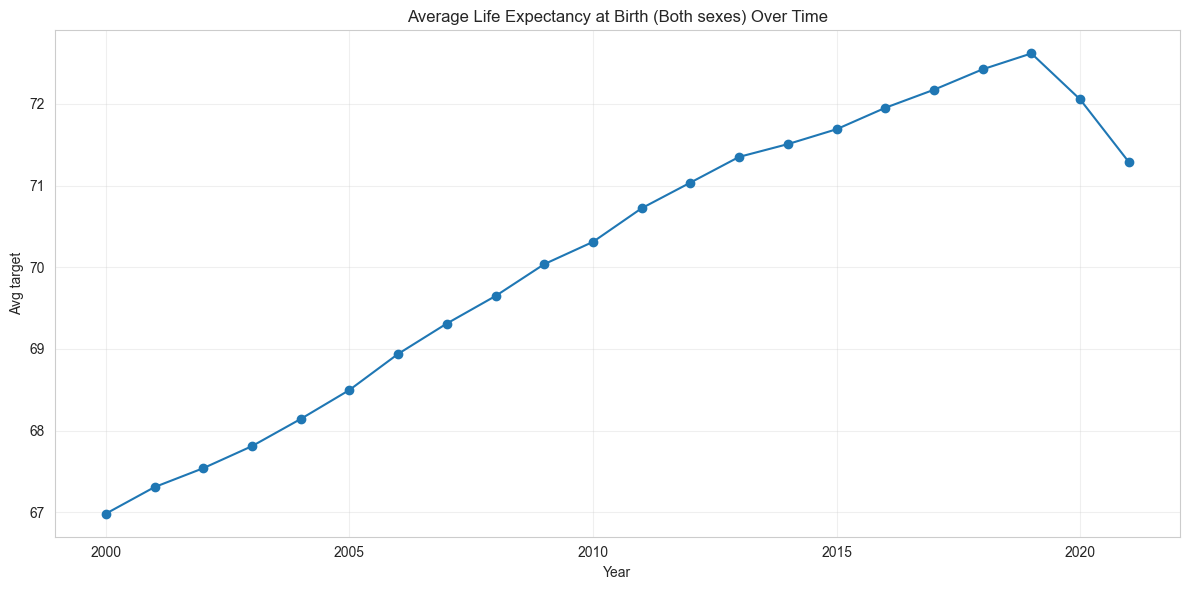

In [11]:
# Summary statistics for target
print("Target summary:")
display(df_simplified[TARGET].describe().to_frame("value"))

# Trend over time (mean target by year)
trend = df_simplified.groupby("Year")[TARGET].mean().reset_index()
plt.figure()
plt.plot(trend["Year"], trend[TARGET], marker="o")
plt.title("Average Life Expectancy at Birth (Both sexes) Over Time")
plt.xlabel("Year")
plt.ylabel("Avg target")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(IMG_DIR / "target_trend_over_time.png", dpi=200, bbox_inches="tight")
plt.show()

### Correlations

In [12]:
# Correlations with target (numeric only)
numeric_cols = df_simplified.select_dtypes(include=[np.number]).columns.tolist()
# Exclude time identifiers from correlation ranking
exclude = {"Year", "Years_Since_2000"}
numeric_cols = [c for c in numeric_cols if c not in exclude]

# For correlation computation, fill missing with column median (keeps the matrix well-defined for plotting)
corr_df = df_simplified[numeric_cols].copy()
corr_df = corr_df.apply(lambda s: s.fillna(s.median()), axis=0)

correlations = corr_df.corr()[TARGET].sort_values(ascending=False)

print("Top 15 features correlated with target:")
display(correlations.head(15).to_frame("corr_with_target"))

print("Bottom 10 features (most negative correlation):")
display(correlations.tail(10).to_frame("corr_with_target"))

Top 15 features correlated with target:


,corr_with_target
life_expectancy_birth_years__both_sexes,1.000000
overweight_adults_bmi_ge_25_pct__both_sexes__18_years,0.621697
gdp_per_capita_const2015_usd,0.544238
immunization_mean_pct,0.480022
alcohol_consumption_litres_15plus__both_sexes,0.364076
health_expenditure_pct_gdp,0.336696
population_total,0.013315
hiv_prevalence_15_49_pct,-0.267021
thinness_mean_pct,-0.452142
underweight_adults_bmi_lt18_pct__both_sexes__18_years,-0.611139


Bottom 10 features (most negative correlation):


,corr_with_target
immunization_mean_pct,0.480022
alcohol_consumption_litres_15plus__both_sexes,0.364076
health_expenditure_pct_gdp,0.336696
population_total,0.013315
hiv_prevalence_15_49_pct,-0.267021
thinness_mean_pct,-0.452142
underweight_adults_bmi_lt18_pct__both_sexes__18_years,-0.611139
infant_deaths_per_1000_population,-0.789439
under5_mortality_rate_per_1000__both_sexes,-0.870243
adult_mortality_rate_15_60_per_1000__both_sexes,-0.938141


### Correlation Heatmap (Top 10 features)

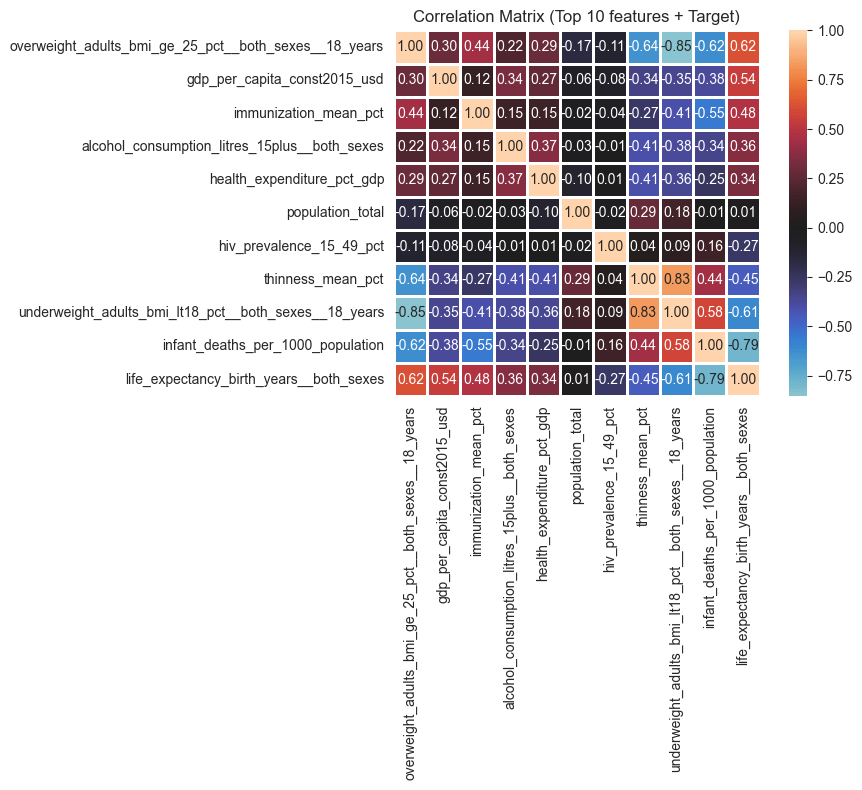

In [13]:
top_features = correlations.head(11).index.tolist()
if TARGET in top_features:
    top_features.remove(TARGET)

heat_cols = top_features[:10] + [TARGET]
corr_mat = corr_df[heat_cols].corr()

plt.figure(figsize=(10, 8))
if HAS_SEABORN:
    sns.heatmap(corr_mat, annot=True, fmt=".2f", center=0, square=True, linewidths=1)
else:
    plt.imshow(corr_mat.values, aspect="auto")
    plt.xticks(range(len(heat_cols)), heat_cols, rotation=90)
    plt.yticks(range(len(heat_cols)), heat_cols)
    plt.colorbar()

plt.title("Correlation Matrix (Top 10 features + Target)")
plt.tight_layout()
plt.savefig(IMG_DIR / "correlation_heatmap_top10.png", dpi=200, bbox_inches="tight")
plt.show()

### Distributions of Top Features

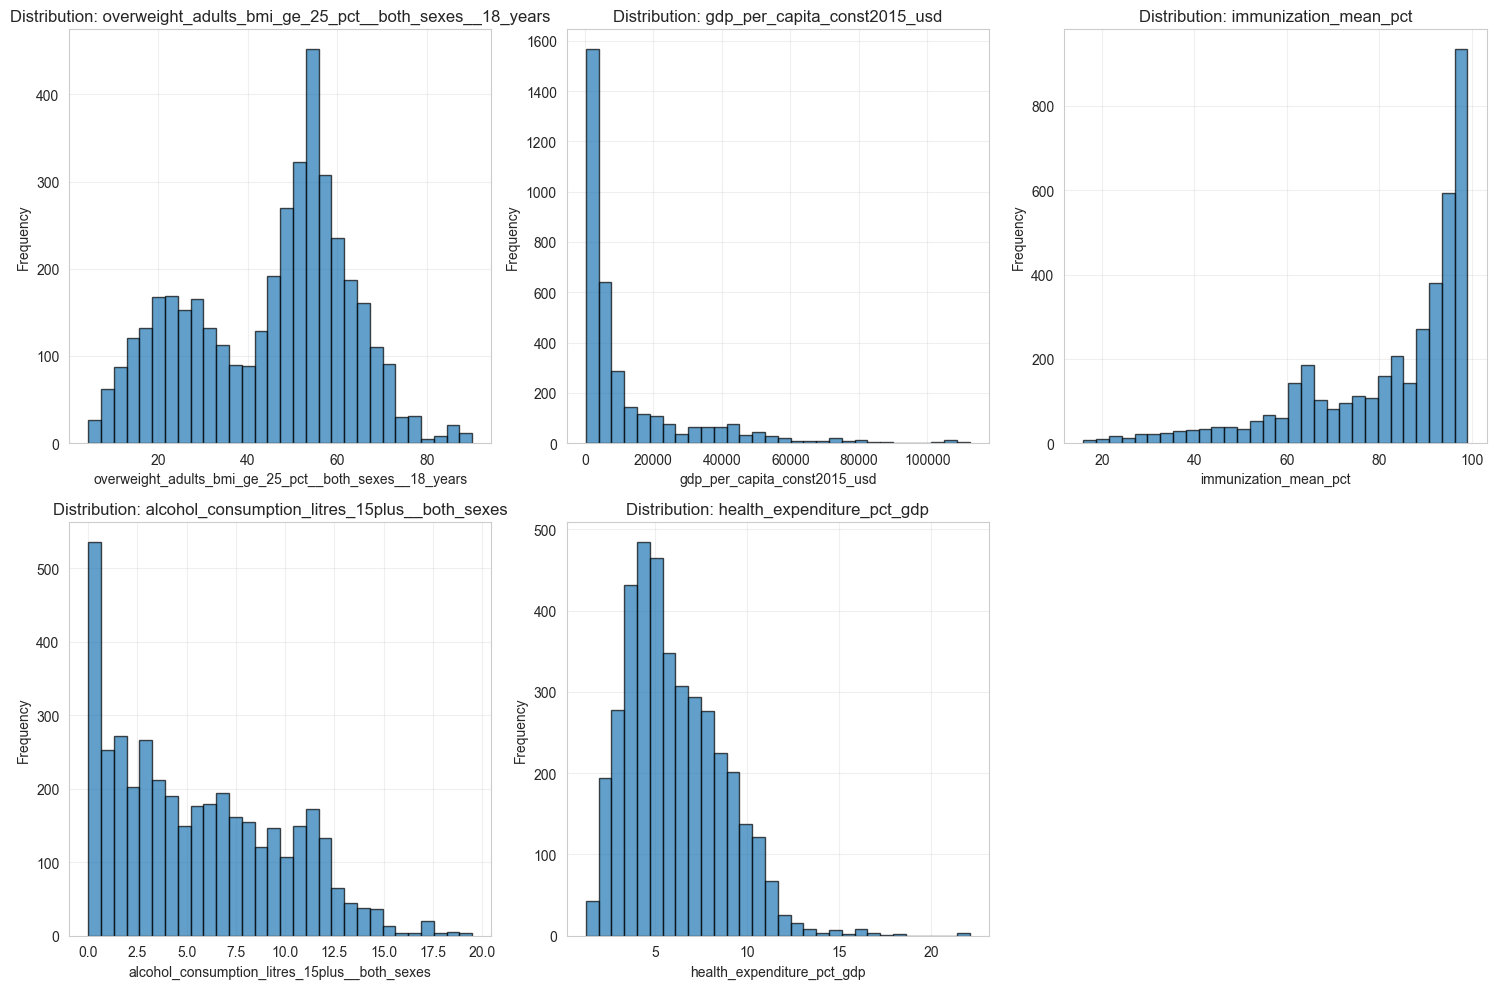

In [14]:
top_5 = correlations.head(6).index.tolist()
if TARGET in top_5:
    top_5.remove(TARGET)
top_5 = top_5[:5]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_5):
    axes[idx].hist(df_simplified[feature].dropna(), bins=30, edgecolor="black", alpha=0.7)
    axes[idx].set_title(f"Distribution: {feature}")
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Frequency")
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplot(s)
for j in range(len(top_5), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(IMG_DIR / "top_features_distributions.png", dpi=200, bbox_inches="tight")
plt.show()

### Scatter Plots (Target vs Most Correlated Features)

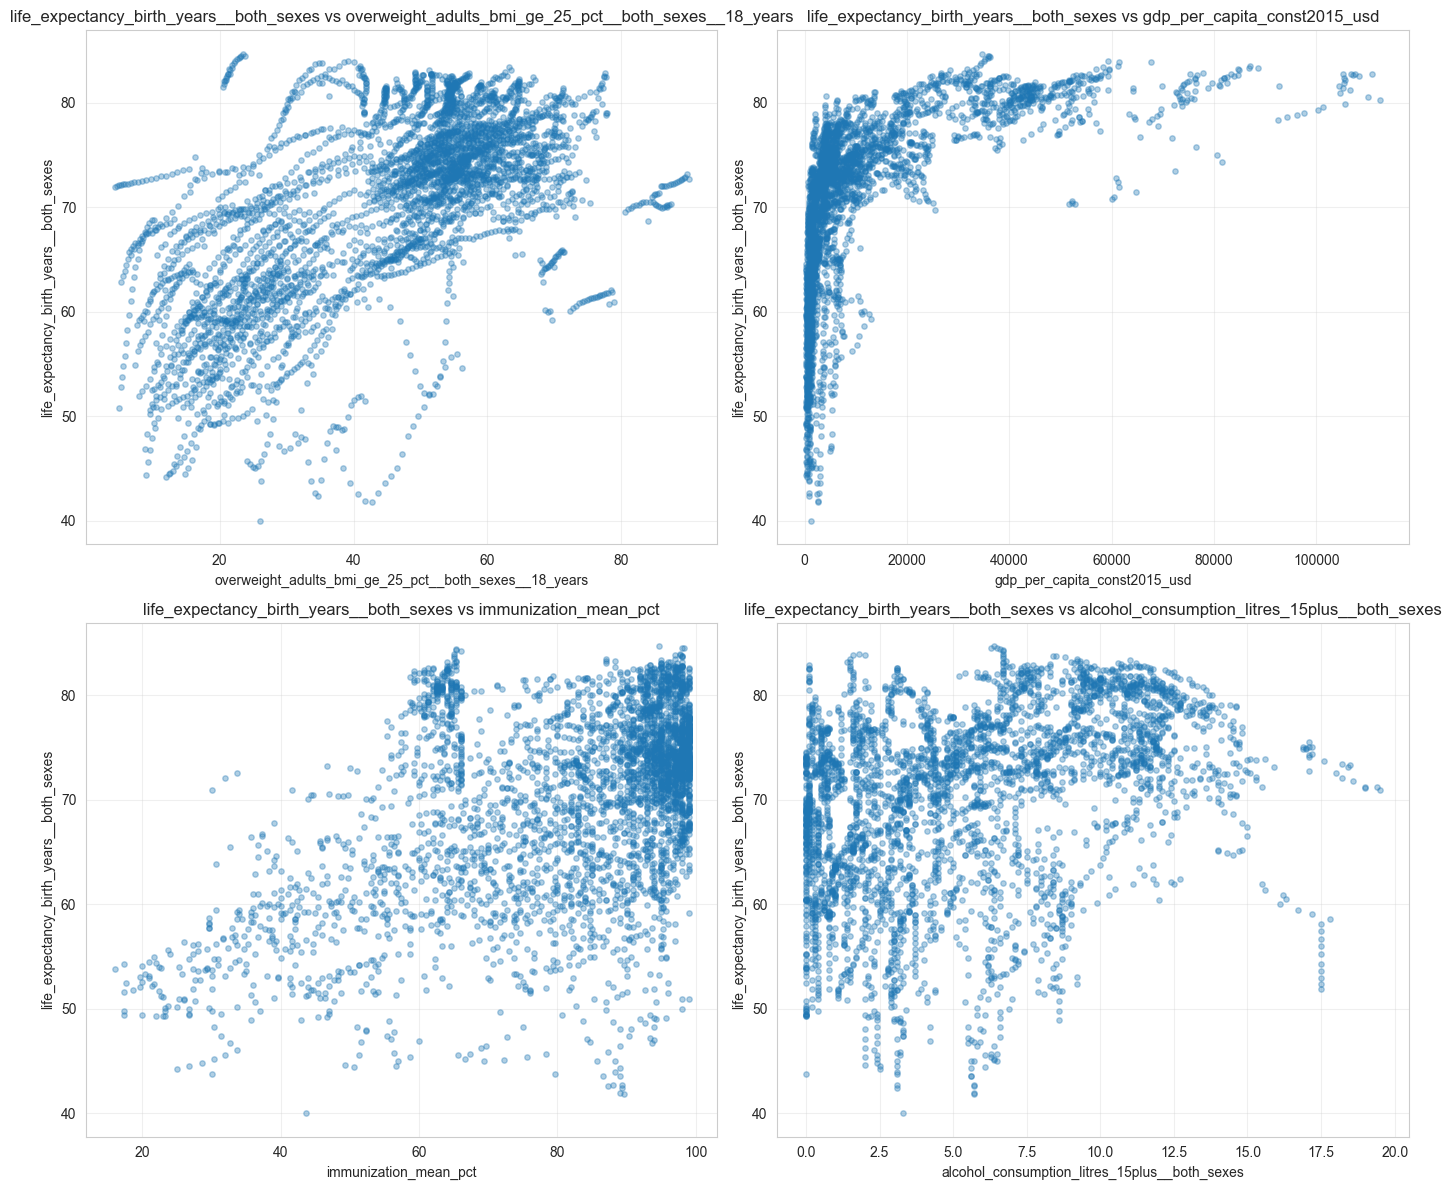

In [15]:
top_pos = [c for c in correlations.index if c != TARGET][:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_pos):
    axes[idx].scatter(df_simplified[feature], df_simplified[TARGET], alpha=0.35, s=15)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel(TARGET)
    axes[idx].set_title(f"{TARGET} vs {feature}")
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(IMG_DIR / "scatter_top_features.png", dpi=200, bbox_inches="tight")
plt.show()

## Train/Test Split (Time-based)

The original notebook deferred imputation to modeling to avoid leakage.  
Here, we make that explicit:

- **Split by year** (train uses earlier years; test uses the most recent years with target data)
- **Fit imputers using train only**
- Apply to both train and test

In [16]:
# Choose a time-based split automatically: last 3 years available become TEST
available_years = sorted(df_simplified["Year"].unique())
# Keep only years that exist after target filtering
available_years = [int(y) for y in available_years if pd.notna(y)]

test_years = available_years[-3:]  # e.g., 2019-2021
train_years = [y for y in available_years if y not in test_years]

df_train = df_simplified[df_simplified["Year"].isin(train_years)].copy()
df_test  = df_simplified[df_simplified["Year"].isin(test_years)].copy()

print("Train years:", min(train_years), "to", max(train_years), f"(n={len(train_years)})")
print("Test years:", test_years)

print("\nSplit sizes:")
print("Train rows:", df_train.shape[0])
print("Test rows: ", df_test.shape[0])
print("Train countries:", df_train["Country"].nunique())
print("Test countries: ", df_test["Country"].nunique())

# Save raw splits (still may contain missing values)
(df_train).to_csv(SPLIT_DIR / "train_raw.csv", index=False)
(df_test).to_csv(SPLIT_DIR / "test_raw.csv", index=False)
print("Saved raw splits to:", SPLIT_DIR.resolve())

Train years: 2000 to 2018 (n=19)
Test years: [2019, 2020, 2021]

Split sizes:
Train rows: 3515
Test rows:  555
Train countries: 185
Test countries:  185
Saved raw splits to: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Codes/outputs/splits


## Build the Model-Ready Dataset (Missing Flags + Train-only Imputation)

To maximize usable rows for modeling (without dropping data):
- Add `missing_*` indicator features for each predictor
- Impute using **train-only medians**:
  1) fill missing with the **country median** computed from training years
  2) then fill any remaining with the **global median** from training years

This keeps the dataset large while respecting time-based leakage concerns.

In [17]:
# Define ID + target + candidate feature columns
id_cols = ["Country", "Year", "Years_Since_2000"]
target_col = TARGET

# Use all numeric columns except target and time identifiers, plus engineered composites already created
all_numeric = df_simplified.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in all_numeric if c not in [target_col, "Year", "Years_Since_2000"]]

# Keep population_total (even though used in infant death rate), it's a meaningful predictor.
# If you prefer to drop it, comment this block out.
if "population_total" not in feature_cols and "population_total" in df_simplified.columns:
    feature_cols.append("population_total")

# Ensure unique order
feature_cols = list(dict.fromkeys(feature_cols))

print("Number of features (pre-missing-flags):", len(feature_cols))
print(feature_cols)

def add_missing_flags(df_in, cols):
    df_out = df_in.copy()
    for c in cols:
        df_out[f"missing_{c}"] = df_out[c].isna().astype(int)
    return df_out

def fit_train_imputer(train_df, group_col, cols):
    country_medians = train_df.groupby(group_col)[cols].median()
    global_medians = train_df[cols].median()
    return country_medians, global_medians

def apply_train_imputer(df_in, group_col, cols, country_medians, global_medians):
    df_out = df_in.copy()
    for c in cols:
        # fill with training country median for that country
        df_out[c] = df_out[c].fillna(df_out[group_col].map(country_medians[c]))
        # then fill with training global median
        df_out[c] = df_out[c].fillna(global_medians[c])
    return df_out

# Add missing flags BEFORE imputation
train_flagged = add_missing_flags(df_train, feature_cols)
test_flagged  = add_missing_flags(df_test, feature_cols)

# Fit imputer on train only, apply to train/test
country_meds, global_meds = fit_train_imputer(df_train, "Country", feature_cols)

train_imp = apply_train_imputer(train_flagged, "Country", feature_cols, country_meds, global_meds)
test_imp  = apply_train_imputer(test_flagged, "Country", feature_cols, country_meds, global_meds)

# Add safe transforms after imputation
for d in [train_imp, test_imp]:
    # log transforms for skewed scale variables
    for col in ["gdp_per_capita_const2015_usd", "population_total", "infant_deaths_per_1000_population"]:
        if col in d.columns:
            d[f"log1p_{col}"] = np.log1p(d[col])

# Final sanity checks
print("Max missing rate in train_imp:", train_imp.isna().mean().max())
print("Max missing rate in test_imp: ", test_imp.isna().mean().max())

# Save splits for modeling
train_imp.to_csv(SPLIT_DIR / "train.csv", index=False)
test_imp.to_csv(SPLIT_DIR / "test.csv", index=False)

print("Saved model-ready splits:")
print(" -", (SPLIT_DIR / "train.csv").resolve())
print(" -", (SPLIT_DIR / "test.csv").resolve())

Number of features (pre-missing-flags): 12
['adult_mortality_rate_15_60_per_1000__both_sexes', 'alcohol_consumption_litres_15plus__both_sexes', 'gdp_per_capita_const2015_usd', 'health_expenditure_pct_gdp', 'hiv_prevalence_15_49_pct', 'overweight_adults_bmi_ge_25_pct__both_sexes__18_years', 'population_total', 'under5_mortality_rate_per_1000__both_sexes', 'underweight_adults_bmi_lt18_pct__both_sexes__18_years', 'immunization_mean_pct', 'thinness_mean_pct', 'infant_deaths_per_1000_population']
Max missing rate in train_imp: 0.0
Max missing rate in test_imp:  0.0
Saved model-ready splits:
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Codes/outputs/splits/train.csv
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Codes/outputs/splits/test.csv


## Data Quality Summary + Export

In [18]:
# Combine back into one final dataset (train + test) for convenience
final_df = pd.concat([train_imp, test_imp], ignore_index=True)
final_df = final_df.sort_values(["Country","Year"]).reset_index(drop=True)

print("FINAL DATASET SUMMARY")
print("Original file:", df.shape)
print("After cleaning (target present):", df_clean.shape)
print("After simplification:", df_simplified.shape)
print("Final model-ready:", final_df.shape)

# Check duplicates
dup_ct = final_df.duplicated(subset=["Country","Year"]).sum()
print("Duplicate Country-Year in final:", dup_ct)

# Check negative values in features that should be non-negative
nonneg_candidates = [c for c in feature_cols if c in final_df.columns]
neg_report = []
for c in nonneg_candidates:
    neg = (final_df[c] < 0).sum()
    if neg > 0:
        neg_report.append((c, int(neg)))

if neg_report:
    print("⚠️ Negative values found in some features (review):")
    display(pd.DataFrame(neg_report, columns=["Feature","Negative_Count"]).sort_values("Negative_Count", ascending=False))
else:
    print("No negative values found in non-negative feature candidates.")

# Exports
final_raw_path = OUT_DIR / "final_raw.csv"
final_path = OUT_DIR / "final.csv"

# final_raw = simplified dataset (can contain missing values)
df_simplified.to_csv(final_raw_path, index=False)

# final = model-ready dataset (missing flags + train-only imputation)
final_df.to_csv(final_path, index=False)

print("\n✅ Saved:")
print(" -", final_raw_path.resolve())
print(" -", final_path.resolve())

FINAL DATASET SUMMARY
Original file: (6218, 40)
After cleaning (target present): (4070, 41)
After simplification: (4070, 16)
Final model-ready: (4070, 31)
Duplicate Country-Year in final: 0
No negative values found in non-negative feature candidates.

✅ Saved:
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Codes/outputs/final_raw.csv
 - /Users/bikki/Documents/Projects_Spring_2026/STATS201/Codes/outputs/final.csv
